In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pingouin
import sqlite3
import os
import holidays as h

## 1. SQL Query Analysis

This query is designed to extract all necessary raw data from 8 different tables and combine them into a single, clean table for analysis.
Here are the key logical decisions:
1. `WITH` Clauses (CTEs): Before the main query, two temporary "mini-tables" (`items_agg` and `payments_agg`) were created using Common Table Expressions.
* Why? The `order_items` and `order_payments` tables have a one-to-many relationship with `orders` (one order can have many items). A simple `JOIN` would cause massive data duplication (a "fan-out"), making all `SUM()` calculations incorrect.
* Solution: We first pre-aggregate (using `SUM()` and `GROUP BY`) these tables to get a single row per order_id, which we can then safely join.

2. `LEFT JOIN`: The main query uses `LEFT JOIN` instead of a standard `INNER JOIN`.
* Why? Our goal is to analyze all delivered orders from the main `olist_orders_dataset table`.
Problem: If we used an `INNER JOIN`, any order that was missing a review (or a customer record) would be dropped from our analysis. This would skew our results.
* Solution: `LEFT JOIN` ensures that we keep all rows from the "left" table (`olist_orders_dataset`) and simply fill in `NULL` values for any missing data from the "right" tables (like `review_score`).

3. `WHERE` Clause: The query filters for `order_status = 'delivered'` and checks for `IS NOT NULL`.
* Why? We can only analyze customer satisfaction on orders that were actually completed. Filtering out canceled or shipped orders, as well as rows with missing data, ensures our final dataset is clean and relevant to the business problem.

In [21]:
current_dir = os.getcwd()
big_dir = os.path.dirname(current_dir)
path_db = os.path.join(big_dir, 'data', 'interim', 'olist_database.db')
conn = sqlite3.connect(path_db)
print(f"Connected to database at: {path_db}")

main_query = """
WITH
items_agg AS (
    SELECT
        order_id,
        SUM(price) AS total_product_price,
        SUM(freight_value) AS total_freight_value
    FROM olist_order_items_dataset
    GROUP BY order_id
),

payments_agg AS (
    SELECT
        order_id,
        SUM(payment_value) AS total_payment_value,
        GROUP_CONCAT(payment_type, ', ') AS payment_types
    FROM olist_order_payments_dataset
    GROUP BY order_id
)

SELECT
    -- Ключі
    o.order_id,
    o.customer_id,

    -- Дати
    o.order_purchase_timestamp,
    o.order_delivered_customer_date,
    o.order_estimated_delivery_date,

    -- Клієнт
    c.customer_city,
    c.customer_state,

    -- Відгук
    r.review_score,

    -- Гроші (з WITH-таблиць)
    i.total_product_price,
    i.total_freight_value,
    p.total_payment_value,
    p.payment_types
    
FROM
    olist_orders_dataset AS o
LEFT JOIN
    olist_order_reviews_dataset AS r ON o.order_id = r.order_id
LEFT JOIN
    olist_customers_dataset AS c ON o.customer_id = c.customer_id
LEFT JOIN
    items_agg AS i ON o.order_id = i.order_id  
LEFT JOIN
    payments_agg AS p ON o.order_id = p.order_id 

WHERE
    o.order_status = 'delivered'
    AND o.order_delivered_customer_date IS NOT NULL
    AND o.order_purchase_timestamp IS NOT NULL
    AND o.order_estimated_delivery_date IS NOT NULL
    AND i.total_product_price IS NOT NULL
    AND i.total_product_price > 0
;
"""


print("Executing main SQL query... Це може зайняти хвилину...")
df_main = pd.read_sql_query(main_query, conn)

conn.close()
print(f"Successfully loaded and transformed data! Created DataFrame with {len(df_main)} rows.")

df_main.head()

Connected to database at: d:\my_projects\project_Brazilian_ECommerce_by_Olist\data\interim\olist_database.db
Executing main SQL query... Це може зайняти хвилину...
Successfully loaded and transformed data! Created DataFrame with 96999 rows.


,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,review_score,total_product_price,total_freight_value,total_payment_value,payment_types
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,SP,4.0,29.99,8.72,38.71,"credit_card, voucher, voucher"
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,barreiras,BA,4.0,118.70,22.76,141.46,boleto
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,vianopolis,GO,5.0,159.90,19.22,179.12,credit_card
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15 00:00:00,sao goncalo do amarante,RN,5.0,45.00,27.20,72.20,credit_card
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26 00:00:00,santo andre,SP,5.0,19.90,8.72,28.62,credit_card


## 2. Data Transformation & Enrichment



### Data Preparation & Feature Engineering

Before proceeding to the EDA phase, we performed the following steps to prepare our dataset:

1.  **Data Inspection & Type Conversion:**
    * Used `.info()` and `.describe()` to examine data types and distributions.
    * Converted date columns (`purchase_timestamp`, `delivered_customer_date`, etc.) from `object` to `datetime` format to enable temporal calculations.

2.  **Feature Engineering:**
    * Calculated **Delivery Time**: The actual number of days it took to deliver the order.
    * Created **Is Late**: A binary flag indicating if the delivery exceeded the estimated date.
    * Calculated **Freight Ratio**: The ratio of shipping cost to the product price.

3.  **Data Enrichment:**
    * Used the `holidays` library to create a new column identifying orders placed on Brazilian national holidays.

In [22]:
print(df_main.info())
print(df_main.describe().T)

df_main['order_purchase_timestamp'] = pd.to_datetime(df_main['order_purchase_timestamp'], errors='coerce')
df_main['order_delivered_customer_date'] = pd.to_datetime(df_main['order_delivered_customer_date'], errors='coerce')
df_main['order_estimated_delivery_date'] = pd.to_datetime(df_main['order_estimated_delivery_date'], errors='coerce')

df_main['time_to_deliver_days'] = (df_main['order_delivered_customer_date'] - df_main['order_purchase_timestamp']).dt.days

df_main['is_late'] = np.where(
    df_main['order_delivered_customer_date'] > df_main['order_estimated_delivery_date'],
    1,
    0
)

df_main['freight_to_price_ratio'] = np.where(
    df_main['total_product_price'] > 0,
    df_main['total_freight_value'] / df_main['total_product_price'],
    np.nan
)

brazil_hol = h.Brazil(years=[2015,2016,2017,2018,2019])
df_main['is_holiday_purchase'] = df_main['order_purchase_timestamp'].dt.date.isin(brazil_hol).astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96999 entries, 0 to 96998
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       96999 non-null  object 
 1   customer_id                    96999 non-null  object 
 2   order_purchase_timestamp       96999 non-null  object 
 3   order_delivered_customer_date  96999 non-null  object 
 4   order_estimated_delivery_date  96999 non-null  object 
 5   customer_city                  96999 non-null  object 
 6   customer_state                 96999 non-null  object 
 7   review_score                   96353 non-null  float64
 8   total_product_price            96999 non-null  float64
 9   total_freight_value            96999 non-null  float64
 10  total_payment_value            96998 non-null  float64
 11  payment_types                  96998 non-null  object 
dtypes: float64(4), object(8)
memory usage: 8.9+ MB

### Overall Review Score

In [23]:
print("Starting Exploratory Data Analysis...")

# --- Overall Review Score ---
print("\n--- 1. General statistics on grades ---")
print(f"Mean score: {df_main['review_score'].mean():.2f}")
print("\nDistribution of grades:")
print(df_main['review_score'].value_counts().sort_index())

# Checking for missing values (just in case)
print("\nMissing values:")
print(df_main.isna().sum()[df_main.isna().sum() > 0])

Starting Exploratory Data Analysis...

--- 1. General statistics on grades ---
Mean score: 4.16

Distribution of grades:
review_score
1.0     9405
2.0     2941
3.0     7961
4.0    18987
5.0    57059
Name: count, dtype: int64

Missing values:
review_score           646
total_payment_value      1
payment_types            1
dtype: int64


--- Initial Observations ---
1. High Satisfaction: The average score is 4.16, with the majority of ratings being 5 stars.
2. Polarized Reviews: There is a notable number of 1-star reviews, suggesting critical failures in some orders.
3. Data Quality: Only ~0.6% of review scores are missing, which is negligible.

### 1. Time Analysis: the impact of delays on feedback


--- Impact of lateness (is_late) on rating ---
             mean  count
is_late                 
0        4.293718  88653
1        2.566494   7700


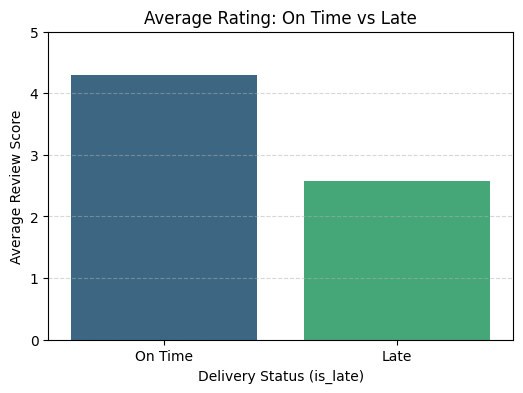


--- Detailed analysis of delivery time (Binning) ---
delivery_bin
Very fast (0-3 days)    4.459981
Fast (4-7 days)         4.390601
Normal (8-14 days)      4.288446
Slow (15+ days)         3.647954
Name: review_score, dtype: float64


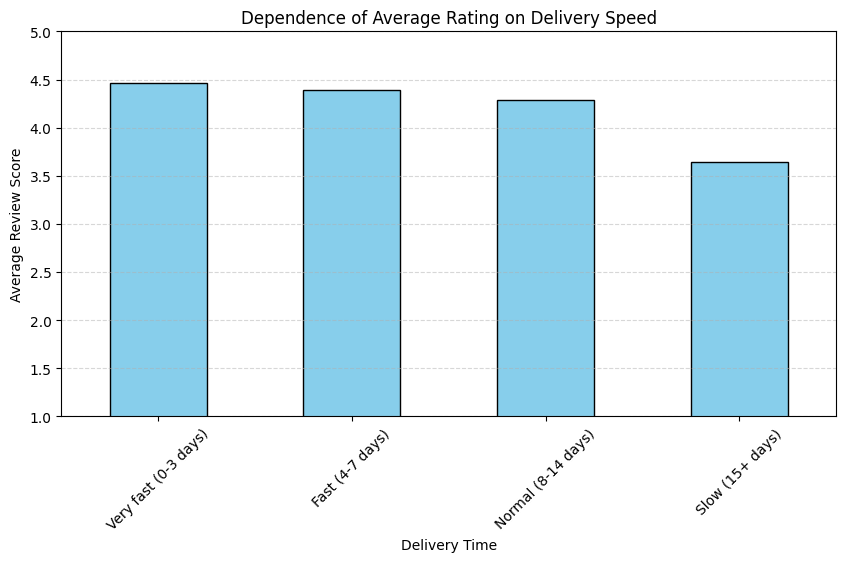

In [24]:
# Hypothesis: 'Does lateness affect the score?' ---
print("\n--- Impact of lateness (is_late) on rating ---")

# Grouping and calculating the mean
late_impact = df_main.groupby('is_late', observed=False)['review_score'].agg(['mean', 'count'])
print(late_impact)

plt.figure(figsize=(6, 4))
sns.barplot(x=late_impact.index, y=late_impact['mean'], hue=late_impact.index, palette='viridis', legend=False)
plt.title('Average Rating: On Time vs Late')
plt.ylabel('Average Review Score')
plt.xlabel('Delivery Status (is_late)')
plt.xticks([0, 1], ['On Time', 'Late'])
plt.ylim(0, 5)  # Scale from 0 to 5
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Hypothesis: "How does delivery time affect rating?" ---
print("\n--- Detailed analysis of delivery time (Binning) ---")

# Creating categories (bins) for delivery time
bins = [-1, 3, 7, 14, float('inf')]
labels = ['Very fast (0-3 days)', 'Fast (4-7 days)', 'Normal (8-14 days)', 'Slow (15+ days)']

df_main['delivery_bin'] = pd.cut(df_main['time_to_deliver_days'], bins=bins, labels=labels)

# Grouping by bins
bin_analysis = df_main.groupby('delivery_bin', observed=False)['review_score'].mean()
print(bin_analysis)

# Visualization
plt.figure(figsize=(10, 5))
bin_analysis.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Dependence of Average Rating on Delivery Speed')
plt.ylabel('Average Review Score')
plt.xlabel('Delivery Time')
plt.ylim(1, 5)  # Focusing on rating range
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### 2. Seasonality analysis: impact of holidays on logistics

In [25]:
print("\n--- Holiday analysis (Chi-square test) ---")

# Creating a contingency table
# Rows: Holiday or not (0/1), Columns: Late or not (0/1)
contingency_table = pd.crosstab(df_main['is_holiday_purchase'], df_main['is_late'])
print("Contingency Table:")
print(contingency_table)

# Performing Chi-square test
chi2, p_value, dof, expected = sp.stats.chi2_contingency(contingency_table)

print(f"\nChi-square test results:")
print(f"P-value: {p_value:.5f}")
alpha = 0.05
if p_value < alpha:
    print("CONCLUSION: There is a statistically significant relationship between holidays and delays.")
else:
    print("CONCLUSION: No statistically significant relationship was found.")

# Calculating % of delays for regular and holiday days
late_rates = df_main.groupby('is_holiday_purchase', observed=False)['is_late'].mean() * 100
print("\nPercentage of delays:")
print(f"On regular days: {late_rates[0]:.2f}%")
print(f"On holidays: {late_rates[1]:.2f}%")


--- Holiday analysis (Chi-square test) ---
Contingency Table:
is_late                  0     1
is_holiday_purchase             
0                    87739  7776
1                     1395    89

Chi-square test results:
P-value: 0.00313
CONCLUSION: There is a statistically significant relationship between holidays and delays.

Percentage of delays:
On regular days: 8.14%
On holidays: 6.00%


### 3. Analysis of the Impact of Delivery Cost


--- Average Score Depending on Delivery Cost ---
freight_bin
Low (<10%)         4.205329
Medium (10-50%)    4.155762
High (>50%)        4.105976
Name: review_score, dtype: float64


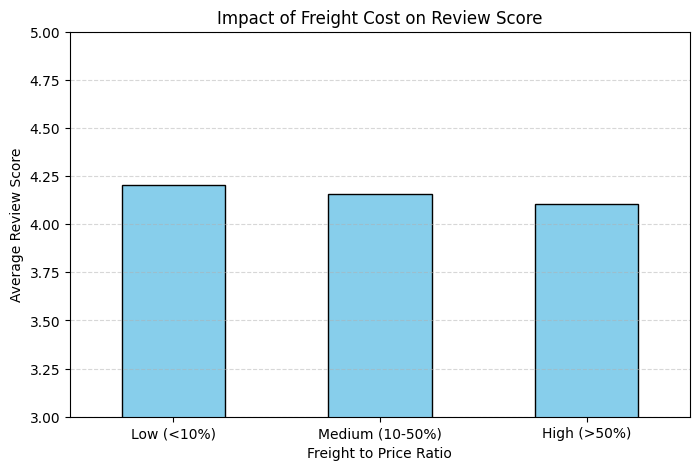


--- Statistical Analysis of Freight Cost Impact (ANOVA) ---
ANOVA Result Table:


,Source,SS,DF,MS,F,p-unc,np2
0,freight_bin,75.209891,2,37.604946,22.785026,1.279170e-10,0.000473
1,Within,159018.315334,96350,1.650424,NaN,NaN,NaN



CONCLUSION: Result is Statistically Significant (p = 0.00000)
The cost of freight DOES affect the review score.

--- Post-hoc Tests (Pairwise Tukey) ---


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Low (<10%),Medium (10-50%),4.205329,4.155762,0.049567,0.011560,4.287762,5.366572e-05,0.038698
1,Low (<10%),High (>50%),4.205329,4.105976,0.099353,0.014718,6.750508,9.449996e-12,0.076937
2,Medium (10-50%),High (>50%),4.155762,4.105976,0.049786,0.011536,4.315590,4.735249e-05,0.038713



--- Detailed Conclusion from Tukey Test ---
1. Every increase in freight cost category significantly lowers the review score.
2. Customers are highly price-sensitive regarding shipping costs.
3. Even a moderate increase (Low -> Medium) negatively impacts satisfaction.
4. The 'High' freight cost group (>50% of product price) has the lowest scores, confirming that high shipping costs are a major pain point.

Business Recommendation: Subsidizing shipping costs or negotiating better logistics rates will directly improve customer satisfaction metrics (NPS/CSAT).


In [26]:
# 1. Create categories for freight-to-price ratio (Low, Medium, High)
bins_freight = [-0.1, 0.1, 0.5, float('inf')]
labels_freight = ['Low (<10%)', 'Medium (10-50%)', 'High (>50%)']

df_main['freight_bin'] = pd.cut(df_main['freight_to_price_ratio'], bins=bins_freight, labels=labels_freight)

# 2. Calculate average review score for each group
freight_score = df_main.groupby('freight_bin', observed=False)['review_score'].mean()

print("\n--- Average Score Depending on Delivery Cost ---")
print(freight_score)

# 3. Visualization
plt.figure(figsize=(8, 5))
freight_score.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Impact of Freight Cost on Review Score')
plt.ylabel('Average Review Score')
plt.xlabel('Freight to Price Ratio')
plt.xticks(rotation=0)
plt.ylim(3, 5)  # "Zoom" the chart to better highlight differences
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()



# ANOVA TEST WITH PINGOUIN
print("\n--- Statistical Analysis of Freight Cost Impact (ANOVA) ---")

aov = pingouin.anova(data=df_main, dv='review_score', between='freight_bin', detailed=True)

print("ANOVA Result Table:")
display(aov)

p_value = aov['p-unc'][0]
if p_value < 0.05:
    print(f"\nCONCLUSION: Result is Statistically Significant (p = {p_value:.5f})")
    print("The cost of freight DOES affect the review score.")
    
    print("\n--- Post-hoc Tests (Pairwise Tukey) ---")
    posthoc = pingouin.pairwise_tukey(data=df_main, dv='review_score', between='freight_bin')
    display(posthoc)
    # === Interpretation of Tukey Test ===
    print("\n--- Detailed Conclusion from Tukey Test ---")

    # Оскільки всі p-value < 0.05, ми можемо стверджувати:
    print("1. Every increase in freight cost category significantly lowers the review score.")
    print("2. Customers are highly price-sensitive regarding shipping costs.")
    print("3. Even a moderate increase (Low -> Medium) negatively impacts satisfaction.")
    print("4. The 'High' freight cost group (>50% of product price) has the lowest scores," \
    " confirming that high shipping costs are a major pain point.")

    print("\nBusiness Recommendation: Subsidizing shipping costs or negotiating better logistics rates" \
    " will directly improve customer satisfaction metrics (NPS/CSAT).")
else:
    print(f"\nCONCLUSION: Not Significant (p = {p_value:.5f})")
    print("Freight cost does not significantly affect the review score.")



### 4. Geographic Analysis: Delivery Performance by State


--- Top 10 States with Highest Late Delivery Rates ---
customer_state
Alagoas           23.94 %
Maranhão          19.56 %
Piauí             15.93 %
Ceará             15.37 %
Sergipe           15.22 %
Bahia             14.08 %
Rio de Janeiro    13.48 %
Tocantins         12.77 %
Pará              12.29 %
Espírito Santo    12.23 %
Name: mean, dtype: object


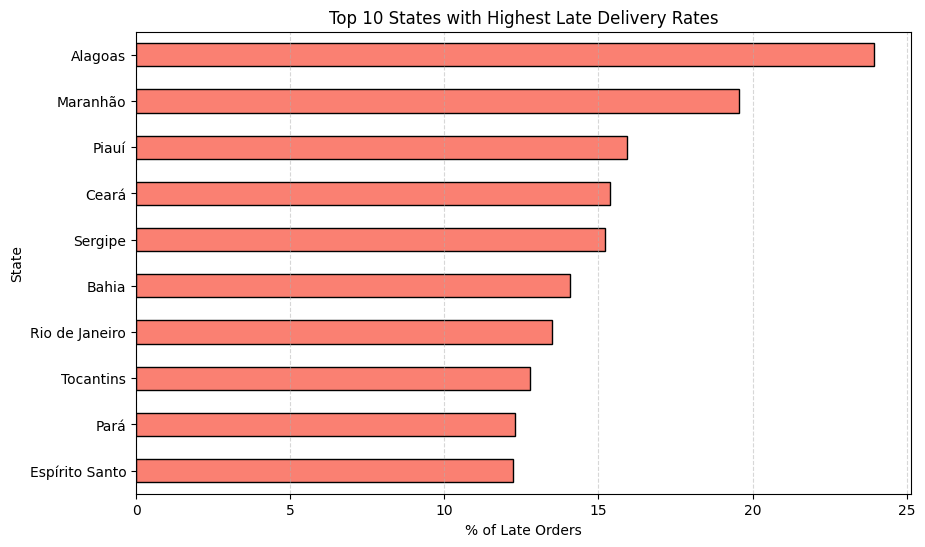

In [27]:
# 1. Create a mapping dictionary for Brazilian states (Abbreviation -> Full Name)
brazil_states_mapping = {
    'AC': 'Acre', 'AL': 'Alagoas', 'AP': 'Amapá', 'AM': 'Amazonas',
    'BA': 'Bahia', 'CE': 'Ceará', 'DF': 'Distrito Federal', 'ES': 'Espírito Santo',
    'GO': 'Goiás', 'MA': 'Maranhão', 'MT': 'Mato Grosso', 'MS': 'Mato Grosso do Sul',
    'MG': 'Minas Gerais', 'PA': 'Pará', 'PB': 'Paraíba', 'PR': 'Paraná',
    'PE': 'Pernambuco', 'PI': 'Piauí', 'RJ': 'Rio de Janeiro', 'RN': 'Rio Grande do Norte',
    'RS': 'Rio Grande do Sul', 'RO': 'Rondônia', 'RR': 'Roraima', 'SC': 'Santa Catarina',
    'SP': 'São Paulo', 'SE': 'Sergipe', 'TO': 'Tocantins'
}

# 2. Group by state and calculate metrics
state_stats = df_main.groupby('customer_state', observed=False)['is_late'].agg(['count', 'mean'])

# 3. Filter: Keep only states with > 50 orders for reliability
state_stats = state_stats[state_stats['count'] > 50]

# 4. RENAME the index (Abbreviations to Full Names) using our dictionary
state_stats = state_stats.rename(index=brazil_states_mapping)

# 5. Sort and select Top 10 worst performing states
worst_states = state_stats.sort_values('mean', ascending=False).head(10)

print("\n--- Top 10 States with Highest Late Delivery Rates ---")
print((worst_states['mean'] * 100).round(2).astype(str) + ' %')

# 6. Visualization
plt.figure(figsize=(10, 6))
(worst_states['mean'] * 100).sort_values().plot(kind='barh', color='salmon', edgecolor='black')

plt.title('Top 10 States with Highest Late Delivery Rates')
plt.xlabel('% of Late Orders')
plt.ylabel('State')
plt.grid(axis='x', linestyle='--', alpha=0.5)

### Key Insights & Intermediate Conclusions from EDA

Based on the statistical analysis and visualizations performed above, we can draw several critical conclusions regarding logistics performance and customer satisfaction:

**1. Delivery Speed & Reliability (The Critical Factor):**
* **Impact of Delays:** There is a massive drop in customer satisfaction when an order is late. The average review score falls from **~4.3 (On Time)** to **~2.6 (Late)**. This confirms that reliability is the single most important driver of the review score.
* **The "14-Day Threshold":** Customers are relatively patient for the first two weeks. Scores remain high (~4.3-4.4) for deliveries taking up to 14 days. However, once delivery exceeds **15 days**, satisfaction drops sharply to **3.6**.

**2. Seasonality (The Holiday Paradox):**
* **Better Performance:** Contrary to the assumption that holidays cause chaos, our analysis shows that the late delivery rate is actually **lower** during holidays (6.00%) compared to regular days (8.14%). This difference is statistically significant (p < 0.05), suggesting effective logistics planning during peak seasons.

**3. Freight Cost Sensitivity:**
* **Price Matters:** The ANOVA and Tukey tests confirm that higher shipping costs negatively impact ratings.
* **Threshold:** The group with **High Freight Cost (>50% of product price)** has the lowest satisfaction. While the drop is less dramatic than with delays, it is statistically significant. Customers are price-sensitive regarding shipping.

**4. Location Analysis:**
* **Regional Disparity:** There is a severe logistical issue in specific states, primarily in the North and Northeast regions. States like **Alagoas (AL)**, **Maranhão (MA)**, and **Piauí (PI)** experience late delivery rates of **20-24%**, which is nearly triple the national average. These regions represent the biggest opportunity for supply chain optimization.

### **Data Export:** Prepared and exported a clean, enriched dataset optimized for visualization in Business Intelligence tools (Power BI).

In [ ]:
# === Створюємо ID для правильного сортування в Power BI ===

# 1. Для delivery_bin
# Створюємо словник: Яка назва -> Який номер по порядку
delivery_sort_map = {
    'Very fast (0-3 days)': 1,
    'Fast (4-7 days)': 2,
    'Normal (8-14 days)': 3,
    'Slow (15+ days)': 4
}
# Створюємо новий стовпчик з цифрами
df_main['delivery_bin_id'] = df_main['delivery_bin'].map(delivery_sort_map)

# 2. Для freight_bin
freight_sort_map = {
    'Low (<10%)': 1,
    'Medium (10-50%)': 2,
    'High (>50%)': 3
}
df_main['freight_bin_id'] = df_main['freight_bin'].map(freight_sort_map)

# Перевірка
print(df_main[['delivery_bin', 'delivery_bin_id', 'freight_bin', 'freight_bin_id']].head())

# Зберігаємо в папку data
print(df_main.info())
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
processed_data_path = os.path.join(project_root, 'data', 'processed')
final_csv_path = os.path.join(processed_data_path, 'olist_cleaned_for_powerbi.csv')
df_main.to_csv(final_csv_path, index=False)
print(f"SUCCESS: Final clean dataset saved to: {final_csv_path}")

           delivery_bin delivery_bin_id      freight_bin freight_bin_id
0    Normal (8-14 days)               3  Medium (10-50%)              2
1    Normal (8-14 days)               3  Medium (10-50%)              2
2    Normal (8-14 days)               3  Medium (10-50%)              2
3    Normal (8-14 days)               3      High (>50%)              3
4  Very fast (0-3 days)               1  Medium (10-50%)              2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96999 entries, 0 to 96998
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96999 non-null  object        
 1   customer_id                    96999 non-null  object        
 2   order_purchase_timestamp       96999 non-null  datetime64[ns]
 3   order_delivered_customer_date  96999 non-null  datetime64[ns]
 4   order_estimated_delivery_date  96999 non-null  datet